# Mads's linearized forward-Euler integration

In [1]:
using Interact
using PyPlot

INFO: Loading help data...


In [79]:
function temp_balance(ΔT,Δf,Δd;τ=0.797,ρ=0.157,δ=0.193)
    """ Implementation of linearized forward-Euler integration
    of transmission line temperature. Based on IEEE Standard 738
    and Mads's 2015 MPC paper.
    
    Returns change in temperature at next time step based on
    values from current step.
    """
    
    return τ*ΔT + ρ*Δf + δ*Δd
end

temp_balance (generic function with 1 method)

In [3]:
τ = 0.797
ρ = 0.157
δ = 0
Sb = 100e6 # VA
Rij = 110e-6 # Ohms/m
Ilim = 439 # A
length = 88514. # m

max_time = 10 # minutes
temp_limit = 63. # Celsius
start_temp = 55. # Celsius

55.0

In [21]:
ΔT0 = start_temp - temp_limit

-8.0

In [24]:
ΔT0*τ^max_time

-0.8273193859729461

In [43]:
f_loss = 0.5
delta_f = f_loss*Sb/(3*length) - Rij*Ilim^2
ρ*delta_f*(1-(τ^max_time))/(1-τ)

115.86655874902365

In [61]:
temp_balance(-15., 11.,0)

-10.213000000000001

Slider{Float64}([Input{Float64}] 0.25,"f_loss",0.25,0.0:0.01:0.5)

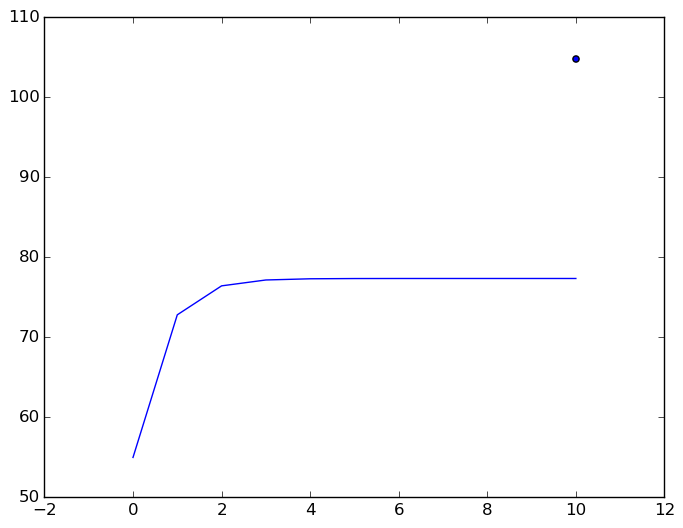

In [80]:
f = figure()
@manipulate for f_loss in 0:0.01:0.5; withfig(f) do
        temp = Array(FloatingPoint,0)
        push!(temp,start_temp)
        delta_f = f_loss*Sb/(3*length) - Rij*Ilim^2
        
        ΔT0 = start_temp - temp_limit
        check = start_temp + (τ^max_time)*ΔT0 + ρ*delta_f*(1-(τ^max_time))/(1-τ)
        for t = 1:max_time
            ΔT = temp_balance(temp[end]-temp_limit, delta_f, 0)
            push!(temp, temp[end] + ΔT)
        end
        plot(temp)
        hold = true
        scatter([max_time],[check])
    end
end

In [39]:
delta_T = Array(FloatingPoint,0)
push!(delta_T, start_temp - temp_limit)

for t = 1:max_time
    push!(delta_T, temp_balance(delta_T[end],delta_f, 0))
end

In [40]:
delta_T

11-element Array{FloatingPoint,1}:
  -8.0   
  19.8659
  42.0471
  59.7034
  73.7578
  84.9451
  93.8502
 100.939 
 106.581 
 111.072 
 114.648 

Linearize about the temperature limit, so begin with negative $\Delta T$. We want to know how much wind deviation it would take to drive $\Delta T$ to zero (i.e., send the line temperature to its maximum allowable value.)

In [8]:
line_lengths = 1609.34*[
    3  
    55  
    22  
    33  
    50  
    31  
     0  
    27  
    23  
    16  
    16  
    42  
    43  
    43  
     0  
     0  
     0  
     0  
    33  
    29  
    33  
    67  
    60  
    52  
    27  
    12  
    34  
    34  
    36  
    18  
    16  
    10  
    73  
    18  
    18  
    27.5
    27.5
    15  
    15  
    47  
    51  
     3  
    55  
    22  
    33  
    50  
    31  
     0  
    27  
    23  
    16  
    16  
    43  
    43  
     0  
     0  
     0  
     0  
    33  
    29  
    33  
    67  
    60  
    27  
    12  
    34  
    34  
    36  
    18  
    16  
    10  
    73  
    18  
    18  
    27.5
    27.5
    15  
    15  
    47  
     3  
    55  
    22  
    33  
    50  
    31  
     0  
    27  
    23  
    16  
    16  
    43  
    43  
     0  
     0  
     0  
     0  
    33  
    29  
    33  
    67  
    60  
    27  
    12  
    34  
    34  
    36  
    18  
    16  
    10  
    73  
    18  
    18  
    27.5
    27.5
    15  
    15  
    47  
    67  
    72  
    0  ]

120-element Array{Float64,1}:
   4828.02
  88513.7 
  35405.5 
  53108.2 
  80467.0 
  49889.5 
      0.0 
  43452.2 
  37014.8 
  25749.4 
  25749.4 
  67592.3 
  69201.6 
      ⋮   
  16093.4 
 117482.0 
  28968.1 
  28968.1 
  44256.8 
  44256.8 
  24140.1 
  24140.1 
  75639.0 
 107826.0 
 115872.0 
      0.0 

## Discussion on recursive behavior of Euler integration

Suppose we are interested in a thirty-minute time horizon. First, we divide this into three ten-minute intervals. We assume that power balance and ambient conditions are fixed during each interval. The temperature change during an interval is found via forward Euler integration of the temperature balance equation. The sample time used for this integration must be less than the conductor's thermal time constant to ensure numerical stability. A sample time of 60s is adequate for the conductors in the RTS-96: Waxwing and Dove ACSR.

To find the temperature at the end of a ten-minute interval, we must know

1. the angle difference across the line during the interval, and
2. line temperature at the beginning of the interval

Unfortunately, this introduces coupling between time steps. It is impossible to calculate the change in temperature during a ten-minute interval without knowing the line temperature at the end of the previous interval.

Because the discretized temperature balance equation represents a linearization of the continuous equation about the temperature limit, we wish to constrain the value of $\Delta T$ during the last ten-minute interval to be 0. This corresponds to the line reaching its highest allowable temperature.

In [76]:
ΔT0 = start_temp - temp_limit
k = (τ/(1-τ))*(1-τ^max_time)
ΔT0*k + (ρ*delta_f/(1-τ))*(max_time - k)

97.12817537550295

In [77]:
τ = 0.797
ρ = 0.157
δ = 0
Sb = 100e6 # VA
Rij = 110e-6 # Ohms/m
Ilim = 439 # A
length = 88514. # m

max_time = 10 # minutes
temp_limit = 63. # Celsius
start_temp = 55. # Celsius

temp = [start_temp]
ΔT = start_temp - temp_limit

delta_f = 25.
for t = 1:max_time
    ΔT = temp_balance(ΔT,delta_f,0,τ=-0.797)
    push!(temp,temp[end] + ΔT)
end

In [78]:
temp

11-element Array{Float64,1}:
 55.0   
 65.301 
 61.0161
 68.3562
 66.4311
 71.8904
 71.4644
 75.7289
 76.2551
 79.7607
 80.8917

# Solution of heat balance IVP with linearized radiative heat rate

The change in temperature of any object may be expressed as a differential equation. This equation, called the heat balance equation, relates change in temperature to a sum of various sources of heating. For a transmission line, these sources are:

* Resistive heating, also known as $I^2R$ losses. This heat source is a function of power flow on the line. In general, the line's resistance varies with temperature, making this calculation more complicated than it appears.

* Convective heating, which is directly proportional to the temperature difference between the line and the surrounding air. If the line is hotter than the surrounding air, it will "give off heat" via convection -- particles moving away from the line will carry energy with them.

* Radiative heating. This heating is related to line and ambient temperatures raised to the fourth power. Physically, thermal radiation is the process by which thermal energy is converted to electromagnetic energy. It takes place in all objects whose abosolute temperature is greater than zero.

* Solar irradiation. The sun imparts energy to the transmission line according. The magnitude of this energy transfer is a function of clouds, geometry, and the line's insulation material. Reflective insulation admits very little solar energy, while black insulation results in significant solar thermal heating.

These heat sources are summed together in the heat balance equation, which tells us how quickly (and in what direction) the transmission line's temperature will change:

$$
\begin{align}
\frac{dT_{avg}}{dt} &= \frac{1}{m\cdot C_p}\left[I^2\cdot R(T_{avg}) - q_c - q_r + q_s \right]
\end{align}
$$

In this equation, $I^2\cdot R(T_{avg})$ represents line losses, $q_c$ is the convective heat rate, $q_r$ is the radiative heat rate, and $q_s$ is the solar heat rate. 

* In our model, $I^2\cdot R(T_{avg})$ is replaced by $f_{ij}^\text{loss}$, the DC approximate line losses.

* The convective heat rate is expressed as $\eta_c\cdot(T - T_\text{amb})$, where $T$ is the line temperature and $T_\text{amb}$ is the ambient temperature. 

* The radiative heat rate is given by $\eta_r\cdot\left[(T + 273)^4 - (T_\text{amb} + 273)^4\right]$.

* The solar heat rate is fixed to some conservative constant (say, full direct sun).

When the heat balance is combined with a given initial temperature, the resulting initial value problem makes it possible to determine the temperature at some later time. Let's substitute what we know into the differential equation and attempt to solve it:

$$
\begin{align}
\dot{T}(t) &= \frac{1}{mC_p}\left[ f_{ij}^\text{loss} - \eta_c\left( T(t) - T_\text{amb}\right) - \eta_r\left((T(t) + 273)^4 - (T_\text{amb} + 273)^4\right) + q_s \right]
\end{align}
$$

Suppose that power flow, ambient temperature, and solar heat rate are constant during the temperature change calculation. Then there are only two variable terms on the right-hand side: one first-order, one fourth-order. The fourth-order term (which corresponds to radiative heat loss) makes this equation difficult to solve. Fortunately, the radiative heat loss rate behaves approximately linearly over the temperature range we are interested in. The figure below illustrates this linear behavior. (Note that it is better to underestimate the radiative heat loss rate -- this is conservative.)

<img src="../images/rad_approx.png" width=500px>

The green trace is the linearization of $q_r$ about the $T_\text{mid}$, the midpoint between the ambient and limit temperatures. Let's replace $q_r$ by this linear approximation $\tilde{q}_r$:

$$
\begin{align}
\dot{T}(t) &= \frac{1}{mC_p}\left[ f_{ij}^\text{loss} - \eta_c\left( T(t) - T_\text{amb}\right) - \tilde{q}_r + q_s \right]
\end{align}
$$
where

$$
\begin{align}
\tilde{q}_r &= \eta_r  \left( (T_\text{mid} + 273)^4 - (T_\text{amb} + 273)^4\right) + 4\eta_r(T_\text{mid} + 273)^3\cdot(T(t) - T_\text{mid})
\end{align}
$$

After simplification, the approximate heat balance equation becomes

$$
\begin{align}
\dot{T}(t) &= aT(t) + b
\end{align}
$$

where

$$
\begin{align}
a &= \frac{1}{mC_p}\left[ -\eta_c - 4\eta_r(T_\text{mid} + 273)^3 \right] \\
b &= \frac{1}{mC_p}\left[ f_{ij}^\text{loss} + \eta_cT_\text{amb} - \eta_r\left((T_\text{mid} + 273)^4 - (T_\text{amb} + 273)^4\right) + 4\eta_rT_\text{mid}(T_\text{mid} + 273)^3 + q_s \right]
\end{align}
$$

This differential equation has a straightforward solution:

$$
\begin{align}
T(t) &= ke^{at} - \frac{b}{a}
\end{align}
$$

where $k=T(0) + b/a$. Note that $b$ is influenced by power flow (via $f_{ij}^\text{loss}$), but $a$ is not.

# From IVP to optimization constraint

The important thing to note about the temperature IVP solution is that it is influenced only by initial temperature and the angle difference during each time interval. There is therefore a recursive relationship between final temperature and initial temperature that involves only the anle differences. Suppose there are three time intervals, $t_1$, $t_2$, and $t_3$. Then the line temperature at the end of the third interval is given by

\begin{align}
T(t_3) &= k_3 e^{(t_3-t_2)a} - \frac{b_3}{a} \\
&= \left[k_2 e^{(t_2-t_1)a} - \frac{b_2}{a} + \frac{b_3}{a}\right]e^{(t_3-t_2)a} - \frac{b_3}{a} \\
&= \left[\left( T(t_1) + \frac{b_2}{a} \right)e^{(t_2-t_1)a} - \frac{b_2}{a} + \frac{b_3}{a}\right]e^{(t_3-t_2)a} - \frac{b_3}{a} \\
&= \left\lbrace\left[\left(T(t_0) + \frac{b_1}{a}\right) e^{(t_1-t_0)a} - \frac{b_1}{a} + \frac{b_2}{a}\right]e^{(t_2-t_1)a} - \frac{b_2}{a} + \frac{b_3}{a}\right\rbrace e^{(t_3-t_2)a} - \frac{b_3}{a}
\end{align}

The recursive pattern is apparent. Because all time intervals are the same length, $e^{(t_3-t_2)a} = e^{(t_2-t_1)a} = e^{(t_1-t_0)a}$, and we can distribute in the last line above to obtain

\begin{align}
T(t_3) &= (e^{(t_1-t_0)a})^3\left(T(t_0) + \frac{b_1}{a}\right) + (e^{(t_1-t_0)a})^2\left(- \frac{b_1}{a} + \frac{b_2}{a}\right) + (e^{(t_1-t_0)a})\left(- \frac{b_2}{a} + \frac{b_3}{a}\right) - \frac{b_3}{a}
\end{align}

Because power flow data enters through the $b_i$, it makes sense to group terms accordingly:

\begin{align}
T(t_3) &= ((e^{(t_1-t_0)a})^3T(t_0) + \left(\frac{(e^{(t_1-t_0)a})^3}{a} - \frac{(e^{(t_1-t_0)a})^2}{a}\right)b_1 + \left( \frac{(e^{(t_1-t_0)a})^2}{a} - \frac{(e^{(t_1-t_0)a})^1}{a}\right)b_2 + \left(\frac{e^{(t_1-t_0)a}}{a} - \frac{1}{a}\right) b_3
\end{align}

The pattern in the above expression makes it easy to extend $T(t_3)$ to cover the general case $T(t_n)$:

\begin{align}
T(t_n) &= (e^{(t_1 - t_0)a})^n T(t_0) + \frac{1}{a} \sum_{i=1}^n \left( (e^{(t_1-t_0)a})^i - (e^{(t_1-t_0)a})^{i-1} \right)b_{n-i+1}
\end{align}

Ultimately the above expression will be used to constrain a line's final temperature to some limiting value. The remainder of this section will relate the expression back to power flow angles so it can be "plugged in" to the optimization framework.

Recall that $b_n$ depends on the angle difference at time $t_n$:

\begin{align}
b_n &= \frac{1}{mC_p} \left[ \frac{r_{ij}}{x_{ij}^2}\cdot \frac{S_b}{3L_{ij}} \theta_{ij}(t_n)^2 + \eta_cT_\text{amb} - \eta_r\left((T_\text{mid} + 273)^4 - (T_\text{amb} + 273)^4\right) + 4\eta_rT_\text{mid}(T_\text{mid} + 273)^3 + q_s \right] \\
&= c\theta_{ij}(t_n)^2 + d
\end{align}

where

\begin{align}
c &= \frac{r_{ij}S_b}{3 mC_p x_{ij}^2L_{ij}} & d &= \frac{1}{mC_p}\left[ \eta_cT_\text{amb} - \eta_r\left((T_\text{mid} + 273)^4 - (T_\text{amb} + 273)^4\right) + 4\eta_rT_\text{mid}(T_\text{mid} + 273)^3 + q_s \right]
\end{align}

Substitute into the temperature equation:

\begin{align}
T(t_n) &= (e^{(t_1 - t_0)a})^n T(t_0) + \frac{1}{a} \sum_{i=1}^n \left( (e^{(t_1-t_0)a})^i - (e^{(t_1-t_0)a})^{i-1} \right)(c\theta_{ij}(t_{n-i+1})^2 + d)
\end{align}

Expand the sum term:

\begin{align}
\frac{1}{a} \sum_{i=1}^n \left( (e^{(t_1-t_0)a})^i - (e^{(t_1-t_0)a})^{i-1} \right)(c\theta_{ij}(t_{n-i+1})^2 + d) &= \frac{c}{a}\left[ \sum_{i=1}^n \left( (e^{(t_1-t_0)a})^i - (e^{(t_1-t_0)a})^{i-1} \right)\theta_{ij}(t_{n-i+1})^2\right] + \\ & \qquad + \frac{d}{a}\left[ \sum_{i=1}^n \left( (e^{(t_1-t_0)a})^i - (e^{(t_1-t_0)a})^{i-1} \right)\right] 
\end{align}

Substitute into the line temperature equation, introducing the constant $f$ to keep things a bit neater:

\begin{align}
T(t_n) &= f + \frac{c}{a}\left[ \sum_{i=1}^n \left( (e^{(t_1-t_0)a})^i - (e^{(t_1-t_0)a})^{i-1} \right)\theta_{ij}(t_{n-i+1})^2\right]
\end{align}

where

\begin{align}
f &= (e^{(t_1 - t_0)a})^n T(t_0) + \frac{d}{a}\left[ \sum_{i=1}^n \left( (e^{(t_1-t_0)a})^i - (e^{(t_1-t_0)a})^{i-1} \right)\right]
\end{align}

Solve for angle differences:

\begin{align}
\sum_{i=1}^n \left( (e^{(t_1-t_0)a})^i - (e^{(t_1-t_0)a})^{i-1} \right)\theta_{ij}(t_{n-i+1})^2 &= \frac{a}{c}(T(t_n) - f)
\end{align}

Now define $\hat{\theta}_{ij}(t_{k})=  \theta_{ij}(t_k)\sqrt{ (e^{(t_1-t_0)a})^{n-k+1} - (e^{(t_1-t_0)a})^{n-k} } $ to obtain

\begin{align}
\sum_{k=1}^n \hat{\theta}_{ij}(t_{k})^2 &= \frac{a}{c}\left(T(t_n) - f\right)
\end{align}

This expression may be used to constrain line temperature to be equal to some limiting value by the end of the last time interval.

## Summary of line temperature constraint

Suppose our time horizon consists of $n$ intervals, each on the order of ten minutes long. Power flow data is updated after each interval, but all other parameters remain constant. We choose a single transmission line in the network, the line between nodes $i$ and $j$. This line has a thermal limit of $T_\text{lim}$ degrees Celsius. We can constrain the line's temperature to be equal to this limiting value by enforcing the second-order constraint:

\begin{align}
\sum_{k=1}^n \hat{\theta}_{ij}(t_k)^2 &= \frac{a}{c}\left(T(t_n) - f\right)
\end{align}

where

* $\hat{\theta}_{ij}(t_{k})=  \theta_{ij}(t_k)\sqrt{ (e^{(t_1-t_0)a})^{n-k+1} - (e^{(t_1-t_0)a})^{n-k} } $
    * $\theta_{ij}(t_k)$ is the angle difference across line $ij$ at time interval $t_k$.
    * $t_1-t_0$ is the length of each time interval (in seconds)
* $a = \frac{1}{mC_p}\left[ -\eta_c - 4\eta_r(T_\text{mid} + 273)^3 \right]$ has units of $s^{-1}$
    * $mC_p$ is the heat capacity, with units of J/m-$^\circ$C
    * $\eta_c$ is the conductive heat loss rate coefficient, with units of W/m-$^\circ$C
    * $\eta_r$ is the conductive heat loss rate coefficient, with units of W/m-$^\circ$C$^4$
    * $T_\text{mid}$ is the average of ambient temperature $T_\text{amb}$ and limit temperature $T_\text{lim}$, in Celsius
* $c = \frac{r_{ij}S_b}{3 mC_p x_{ij}^2L_{ij}}$ is a constant with units of W/m
    * $r_{ij}$ is resistance of line $ij$ in per unit
    * $x_{ij}$ is reactance of line $ij$ in per unit
    * $S_b$ is the system base (e.g. 100 MVA)
    * $L_{ij}$ is the length of one phase of line $ij$, in m
* $f = (e^{(t_1 - t_0)a})^n T(t_0) + \frac{d}{a}\left[ \sum_{i=1}^n \left( (e^{(t_1-t_0)a})^i - (e^{(t_1-t_0)a})^{i-1} \right)\right]$ is a constant with units of degrees Celsius
    * $T(t_0)$ is the line's initial temperature (steady state temperature under base case power flow condition)
    * $d = \frac{1}{mC_p}\left[ \eta_cT_\text{amb} - \eta_r\left((T_\text{mid} + 273)^4 - (T_\text{amb} + 273)^4\right) + 4\eta_rT_\text{mid}(T_\text{mid} + 273)^3 + q_s \right]$ is a constant with units of W/m
        * $q_s$ is the solar heat gain rate in W/m

## Line temperature simulation

In [1]:
using Interact
using PyPlot

INFO: Loading help data...


In [2]:
# Approximate line heating model: use solution of heat balance IVP
# where the radiative heat rate is approximated linearly.

# Data comes from Waxwing conductors on RTS-96 network:
Tamb = 35 # C
Tlim = 65 # C
Tmid = (Tamb + Tlim)/2 # C
T0 = 46. #Tamb # assume line starts out at ambient temp (not quite realistic)
ηc = 0.955 # W/m-C
ηr = 2.207e-9 # W/m-C^4
mCp = 383. # J/m-C
r_ij = 0.03 # pu (typical value)
x_ij = 0.1 # pu (typical value)
qs = 14.4 # W/m
L_ij = 50e3 # 50 km line
Sb = 100e6 # 100 MVA base
time_intervals = 3 # thirty minutes
time_values = 0:60:600 # ten minutes in 1-min steps

T(t,T0,a,b) = (T0 + b/a).*exp(a*t) - b/a # solution to approx. heat balance IVP

θij = 0.1 # rad (vary this!)
f_loss_pu = r_ij*(θij/x_ij)^2 # pu
f_loss_si = f_loss_pu*Sb/(3*L_ij)

a = mCp\(-ηc - 4*ηr*(Tmid + 273)^3)
b = mCp\( f_loss_si + ηc*Tamb - ηr*((Tmid + 273)^4 - (Tamb+273)^4) + 4*ηr*Tmid*(Tmid + 273)^3 + qs )

0.2050611532182376

Slider{Float64}([Input{Float64}] 0.07,"θij1",0.07,0.0:0.01:0.15)

Slider{Float64}([Input{Float64}] 0.07,"θij2",0.07,0.0:0.01:0.15)

Slider{Float64}([Input{Float64}] 0.07,"θij3",0.07,0.0:0.01:0.15)

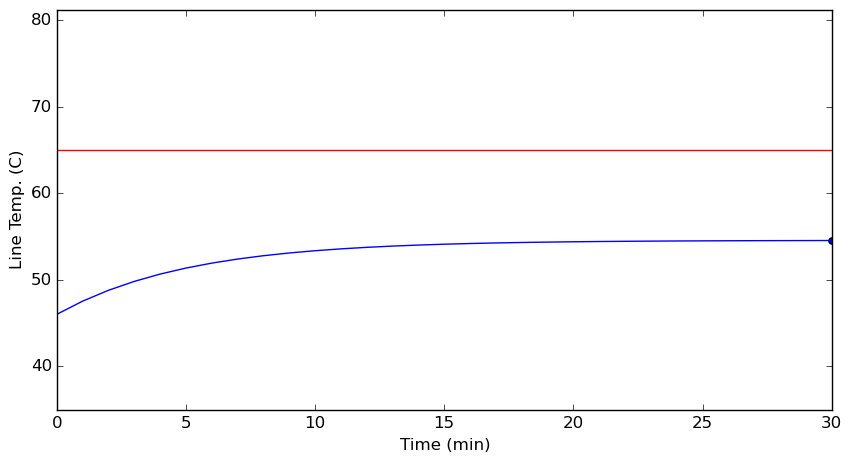

In [3]:
f = figure(figsize=(10,5))
@manipulate for θij1 in 0:0.01:0.15, θij2 in 0:0.01:0.15, θij3 in 0:0.01:0.15; withfig(f) do
        T0 = 46. # C
        
        # Compute final temperature as a function of T0 and angle differences:
        angle_diffs = [θij1,θij2,θij3]
        f_loss_pu_values = [r_ij*(θij/x_ij)^2 for θij in angle_diffs] # pu
        f_loss_si_values = f_loss_pu_values.*Sb/(3*L_ij) # W/m
        b_values = [mCp\( f_loss_si + ηc*Tamb - ηr*((Tmid + 273)^4 - (Tamb+273)^4) + 4*ηr*Tmid*(Tmid + 273)^3 + qs ) for f_loss_si in f_loss_si_values]
        Tfinal = exp(600*a)^3*(T0 + b_values[1]/a) + exp(600*a)^2*(-b_values[1]/a + b_values[2]/a) + exp(600*a)*(-b_values[2]/a + b_values[3]/a) - b_values[3]/a
        
        temp_values = [T0]
        for θij in angle_diffs
            f_loss_pu = r_ij*(θij/x_ij)^2 # pu
            f_loss_si = f_loss_pu*Sb/(3*L_ij) # W/m
            b = mCp\( f_loss_si + ηc*Tamb - ηr*((Tmid + 273)^4 - (Tamb+273)^4) + 4*ηr*Tmid*(Tmid + 273)^3 + qs )
            temp_values = [temp_values,T(time_values,T0,a,b)[2:end]]
            T0 = temp_values[end]
        end
        
        plot(temp_values)
        xlabel("Time (min)")
        ylabel("Line Temp. (C)")
        hold=true
        plot([0,10*time_intervals],[Tlim,Tlim],"red")
        axis([0,10*time_intervals,Tamb,1.25*Tlim])
        #xticks(0:600:(time_intervals*600),0:10:(10*time_intervals))
        scatter([30],[Tfinal])
    end
end

In [10]:
# Clean up temperature calculation
function compute_f_loss_pu(θij,r,x)
    return r*(θij./x).^2
end

function compute_f_loss_si(f_loss_pu,Sb,L)
    return f_loss_pu.*Sb/(3*L)
end

# function compute_qc(T,Tamb,ηc)
#     return ηc*(T - Tamb)
# end

# function compute_qr_approx(T,Tmid,Tamb,ηr)
#     return ηr

function compute_b(θij,mCp,ηc,ηr,Tlim,Tamb,qs)
    f_loss_pu = compute_f_loss_pu(θij,r,x)
    f_loss_si = compute_f_loss_si(f_loss_pu,Sb,L)
    Tmid = (Tlim + Tamb)/2
    
    return mCp\( f_loss_si + ηc*Tamb - ηr*((Tmid + 273)^4 - (Tamb+273)^4) + 4*ηr*Tmid*(Tmid + 273)^3 + qs )
end

function compute_a(mCp,ηc,ηr,Tlim,Tamb)
    Tmid = (Tlim+Tamb)/2
    return mCp\(-ηc - 4*ηr*(Tmid + 273)^3)
end

function compute_T(a,b_values,T0,num_secs,intervals)
    exp_fac = e^(num_secs)
    coeffs = flipud([exp_fac^n for n in 0:intervals])
    temp_vals = [-b_values[n-1]/a + b_values[n]/a for n in 2:intervals]
    sums = [(T0+b_values[1]/a),temp_vals,-b_values[3]/a]
    return dot(coeffs,sums)
end

## Numerical justification for linearized radiative heat rate

Slider{Int64}([Input{Int64}] 75,"Tmax",75,1:150)

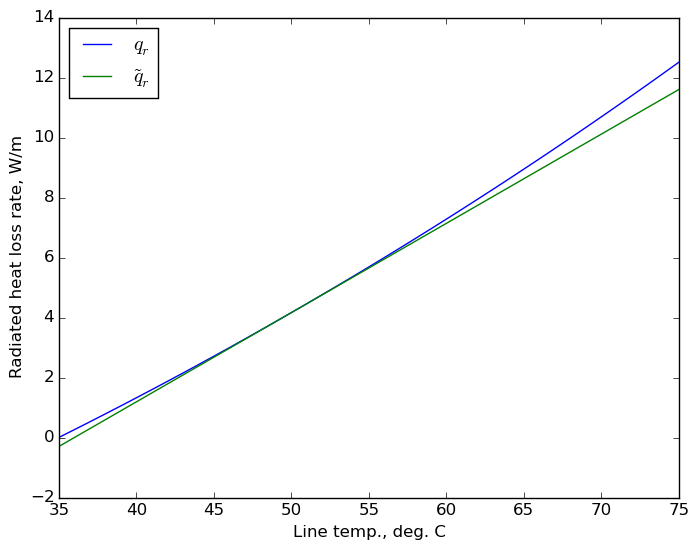

In [22]:
# Approximate radiative heat loss linearly.
# Linearize about the midpoint between ambient and limit temperatures.

rad_rate(T,Tamb,ηr) = ηr*((T+273).^4 - (Tamb+273).^4)

Tamb = 35. # C
Tlim = 65. # C
ηr = 2.207e-9 # W/m-C^4

function rad_rate_approx(T,Tamb,Tlim,ηr)
    Tmid = (Tamb + Tlim)/2
    return ηr*((Tmid + 273).^4 - (Tamb + 273).^4) + (4*ηr*(Tmid + 273).^3)*(T - Tmid)
end

f = figure()
@manipulate for Tmax = 1:150; withfig(f) do
        Trange = Tamb:1:Tmax
        plot(Trange,rad_rate(Trange,Tamb,ηr))
        xlabel("Line temp., deg. C")
        ylabel("Radiated heat loss rate, W/m")
        hold=true
        #plot([Trange[1],Trange[end]],[rad_rate(Trange[1],Tamb,ηr),rad_rate(Trange[end],Tamb,ηr)])
        plot(Trange,rad_rate_approx(Trange,Tamb,Tlim,ηr))
        legend([L"q_r",L"\tilde{q}_r"],loc=2)
    end
end